In [1]:
# !git clone "https://github.com/axchizhov/masked_autoencoder"

In [2]:
# %cd masked_autoencoder
# !pip install -e .

## Hyperparameters

In [3]:
BATCH_SIZE = 256
LR = 1e-4
BETAS = (0.9, 0.95)
NUM_EPOCHS = 100

IMAGE_SIZE = 32
PATCH_SIZE = 2
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
IN_CHANS = 3

ENCODER_EMBED_DIM = 192
ENCODER_NUM_HEADS = 3
ENCODER_DEPTH = 12

DECODER_EMBED_DIM = 192
DECODR_NUM_HEADS = 3
DECODER_DEPTH = 4

SEED = 42

# Preapre data

In [4]:
import torch
import torchvision.transforms as T

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

torch.manual_seed(SEED)

# TODO: fix dataset loading
# TODO: add augmentations

train_data = CIFAR10('../data/', train=True, download=True, transform=T.ToTensor())
# train_data = train_data[:40000]

valid_data = CIFAR10('../data/', train=True, download=True, transform=T.ToTensor())
# valid_data = valid_data[40000:]

test_data = CIFAR10('../data/', train=False, download=True, transform=T.ToTensor())

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Train the autoencoder

In [5]:
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

from src.autoencoder.masked_autoencoder import MaskedAutoencoder
from src.plots import grid_plot, plot_reconstructed


net = MaskedAutoencoder(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    in_chans=IN_CHANS,
    encoder_embed_dim=ENCODER_EMBED_DIM,
    encoder_num_heads=ENCODER_NUM_HEADS,
    encoder_depth=ENCODER_DEPTH,
    decoder_embed_dim=DECODER_EMBED_DIM,
    decoder_num_heads=DECODR_NUM_HEADS,
    decoder_depth=DECODER_DEPTH,
)

optimizer = optim.AdamW(net.parameters(), lr=LR, betas=BETAS)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# Set optimization scheduler
# total_steps = int((len(train_dataloader) / batch_size) * num_epochs)
# warmup_epoch_percentage = 0.15
# warmup_steps = int(total_steps * warmup_epoch_percentage)
# warmup_steps

# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, warmup_steps)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

log_writer = SummaryWriter()

net.train()
step = 1
for epoch in tqdm(range(NUM_EPOCHS)):
    for image_batch, _ in tqdm(train_dataloader, leave=False):
        image_batch = image_batch.to(device)
        optimizer.zero_grad()
        loss, pred, mask = net(image_batch)
        loss.backward()
        optimizer.step()
        
        log_writer.add_scalar("Loss/train", loss.item(), step)
        
        # if step % 20 == 0:
        step += 1
    
    reconstructed = net.unpatchify(pred)
    # plot_reconstructed(image_batch, reconstructed)
    grid = grid_plot(image_batch, reconstructed)
    log_writer.add_image('Original vs Reconstructed', grid, step)
    
    scheduler.step()


# log_writer.add_graph(net, batch)
log_writer.close()

2023-07-31 23:56:40.239620: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 23:56:40.281485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 23:56:41.038027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

KeyboardInterrupt: 

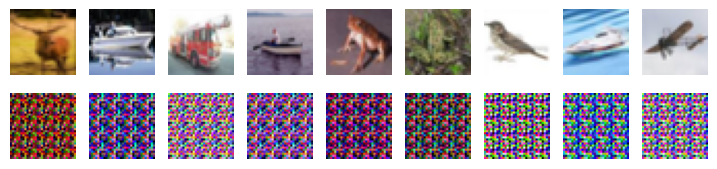

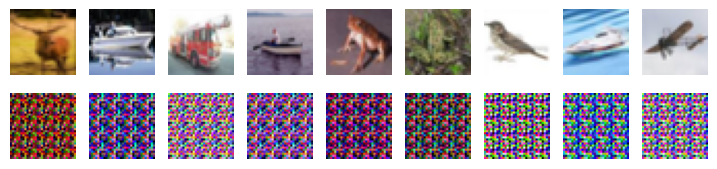

In [ ]:
pred = net.forward_without_mask(image_batch)
reconstructed = net.unpatchify(pred)
plot_reconstructed(image_batch, reconstructed)

In [ ]:
# # evaluate accuracy after training
# model.eval()
# y_pred = model(X_test)
# acc = (y_pred.round() == y_test).float().mean()
# acc = float(acc)
# print("Model accuracy: %.2f%%" % (acc*100))